In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from zipfile import ZipFile

from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

# **DATA UNDERSTANDING**

In [ ]:
links = pd.read_csv('/content/links.csv')
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')
tags = pd.read_csv('/content/tags.csv')

In [ ]:
print('Jumlah data links : ', len(links.movieId.unique()))
print('Jumlah data movies : ', len(movies.movieId.unique()))
print('Jumlah data ratings dari user : ', len(ratings.userId.unique()))
print('Jumlah data ratings  : ', len(ratings.movieId.unique()))
print('Jumlah data tags : ', len(tags.movieId.unique()))

Jumlah data links :  9742
Jumlah data movies :  9742
Jumlah data ratings dari user :  610
Jumlah data ratings  :  9724
Jumlah data tags :  1572


# **UNIVARIATE EXPLORATORY DATA ANALYSIS**

**Links Variabel**

In [ ]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [ ]:
print('Banyak data: ', len(links.movieId.unique()))
print('Banyak imdbId: ', len(links.imdbId.unique()))
print('Banyak tmdbId: ', len(links.tmdbId.unique()))

Banyak data:  9742
Banyak imdbId:  9742
Banyak tmdbId:  9734


**Movies Variabel**

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [ ]:
print('Banyak data: ', len(movies.movieId.unique()))
print('Banyak Title: ', len(movies.title.unique()))
print('Jumlah Genre: ', len(movies.genres.unique()))

Banyak data:  9742
Banyak Title:  9737
Jumlah Genre:  951


**Ratings Variabel**

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [ ]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
print('Jumlah data rating: ', len(ratings))
print('Jumlah userId: ', len(ratings.userId.unique()))
print('Jumlah placeId: ', len(ratings.movieId.unique()))

Jumlah data rating:  100836
Jumlah userId:  610
Jumlah placeId:  9724


# **DATA PREPROCESSING**

**Menggabungkan Movies**

In [ ]:
# Menggabungkan seluruh movieId pada kategori movies
all_movies = np.concatenate((
    links.movieId.unique(),
    movies.movieId.unique(),
    ratings.movieId.unique(),
    tags.movieId.unique(),
))

# Mengurutkan data dan menghapus data yang sama
all_movies = np.sort(np.unique(all_movies))
 
print('Jumlah seluruh data movie berdasarkan movieId: ', len(all_movies))

Jumlah seluruh data movie berdasarkan movieId:  9742


**Menggabungkan Seluruh User**

In [ ]:
# Menggabungkan seluruh userId
all_user = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique(),
))
 
# Menghapus data yang sama kemudian mengurutkannya
all_user = np.sort(np.unique(all_user)) 
 
print('Jumlah seluruh user: ', len(all_user))

Jumlah seluruh user:  610


**Mengetahui Jumlah Rating**

In [ ]:
# Menggabungkan file links, movies, tags ke dalam dataframe movies_info 
movies_info = pd.concat([links, movies, tags])
 
# Menggabungkan dataframe ratings dengan movies_info berdasarkan nilai moviesId
movies_data = pd.merge(ratings, movies_info , on='movieId', how='left')
movies_data

,userId_x,movieId,rating,timestamp_x,imdbId,tmdbId,title,genres,userId_y,tag,timestamp_y
0,1,1,4.0,964982703,114709.0,862.0,NaN,NaN,NaN,NaN,NaN
1,1,1,4.0,964982703,NaN,NaN,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,NaN
2,1,1,4.0,964982703,NaN,NaN,NaN,NaN,336.0,pixar,1.139046e+09
3,1,1,4.0,964982703,NaN,NaN,NaN,NaN,474.0,pixar,1.137207e+09
4,1,1,4.0,964982703,NaN,NaN,NaN,NaN,567.0,fun,1.525286e+09
...,...,...,...,...,...,...,...,...,...,...,...
434880,610,168252,5.0,1493846352,NaN,NaN,NaN,NaN,567.0,gritty,1.525284e+09
434881,610,168252,5.0,1493846352,NaN,NaN,NaN,NaN,567.0,heartbreaking,1.525284e+09
434882,610,168252,5.0,1493846352,NaN,NaN,NaN,NaN,567.0,predictible plot,1.525284e+09
434883,610,170875,3.0,1493846415,4630562.0,337339.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Cek missing value dengan fungsi isnull()
movies_data.isnull().sum()

userId_x            0
movieId             0
rating              0
timestamp_x         0
imdbId         334049
tmdbId         334062
title          334049
genres         334049
userId_y       201672
tag            201672
timestamp_y    201672
dtype: int64

In [ ]:
# Menghitung jumlah ratings kemudian menggabungkannya berdasarkan movieId
movies_data.groupby('movieId').sum()

,userId_x,rating,timestamp_x,imdbId,tmdbId,userId_y,timestamp_y
movieId,,,,,,,
1,329520,4215.0,1214572277395,24662435.0,185330.0,296055.0,8.173308e+11
2,217506,2265.0,749631499932,12484670.0,972840.0,72600.0,6.296298e+11
3,58988,678.0,209062937544,5887856.0,811304.0,30056.0,1.189162e+11
4,3078,33.0,12580104096,804195.0,219499.0,0.0,0.000000e+00
5,58716,602.0,194562210376,5539009.0,581238.0,46452.0,1.114626e+11
...,...,...,...,...,...,...,...
193581,368,8.0,3074218164,5476944.0,432131.0,0.0,0.000000e+00
193583,368,7.0,3074219090,5914996.0,445030.0,0.0,0.000000e+00
193585,368,7.0,3074219610,6397426.0,479308.0,0.0,0.000000e+00


In [ ]:
# Definisikan dataframe ratings ke dalam variabel all_rate_movie
all_rate_movie = ratings
all_rate_movie

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
# Menggabungkan all_rate_movie dengan dataframe movies berdasarkan movieId
all_rate_movie = pd.merge(all_rate_movie, movies[['movieId','title','genres']], on='movieId', how='left')
all_rate_movie
 
# Print dataframe all_rate_movie
all_rate_movie

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


**Menggabungkan Data dengan Fitur tags Movies**

In [ ]:
# Menggabungkan dataframe tags dengan all_rate_movies dan memasukkannya ke dalam variabel all_movies
all_movies = pd.merge(all_rate_movie, tags[['movieId','tag']], on='movieId', how='left')
all_movies

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking
285760,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,predictible plot


# **DATA PREPARATION**

**Mengatasi Missing Value**

In [24]:
# Mengecek missing value pada dataframe all_movies
all_movies.isnull().sum()

userId           0
movieId          0
rating           0
timestamp        0
title            0
genres           0
tag          52549
dtype: int64

In [25]:
# Membersihkan missing value dengan fungsi dropna()
all_movies_clean = all_movies.dropna()
all_movies_clean

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,moldy
4,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,old
...,...,...,...,...,...,...,...
285756,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,dark
285757,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,emotional
285758,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,gritty
285759,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi,heartbreaking


In [26]:
# Mengecek kembali missing value pada variabel all_movies_clean
all_movies_clean.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

In [27]:
# Mengurutkan movie berdasarkan movieId kemudian memasukkannya ke dalam variabel fix_movies
fix_movies = all_movies_clean.sort_values('movieId', ascending=True)
fix_movies 

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121430,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121431,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
121432,275,1,5.0,1049076484,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
35190,73,1,4.5,1464196374,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
263644,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster


In [28]:
# Mengecek berapa jumlah fix_movies
print("jumlah fix_movies : ", len(fix_movies.movieId.unique()))

jumlah fix_movies :  1554


In [29]:
# Membuat variabel preparation yang berisi dataframe fix_resto kemudian mengurutkan berdasarkan placeID
preparation = fix_movies
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44427,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
44426,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
44425,98,1,4.5,1532457849,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
209733,453,1,5.0,1005966797,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
...,...,...,...,...,...,...,...
191470,414,187595,3.5,1527977920,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,star wars
81534,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,remaster
81531,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,anime
81532,184,193565,3.5,1537098554,Gintama: The Movie (2010),Action|Animation|Comedy|Sci-Fi,comedy


In [30]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres,tag
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
187260,414,2,3.0,961594981,Jumanji (1995),Adventure|Children|Fantasy,fantasy
106951,240,3,4.0,849122858,Grumpier Old Men (1995),Comedy|Romance,old
19921,45,5,3.0,959625102,Father of the Bride Part II (1995),Comedy,pregnancy
115692,262,7,3.0,840306238,Sabrina (1995),Comedy|Romance,remake
...,...,...,...,...,...,...,...
27632,62,183611,4.0,1526244681,Game Night (2018),Action|Comedy|Crime|Horror,Comedy
174264,380,184471,3.0,1536872748,Tomb Raider (2018),Action|Adventure|Fantasy,Alicia Vikander
44721,98,187593,5.0,1532457913,Deadpool 2 (2018),Action|Comedy|Sci-Fi,sarcasm
263643,586,187595,5.0,1529899556,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi,Emilia Clarke


In [31]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movies_id = preparation['movieId'].tolist()
 
# Mengonversi data series ‘title’ menjadi dalam bentuk list
movies_title = preparation['title'].tolist()
 
# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movies_genre = preparation['genres'].tolist()
 
print(len(movies_id))
print(len(movies_title))
print(len(movies_genre))

1554
1554
1554


In [32]:
# Membuat dictionary untuk data ‘movies_id’, ‘mobies_title’, dan ‘movies_genre’
new_movies = pd.DataFrame({
    'id': movies_id,
    'movies_title': movies_title,
    'movies_genre': movies_genre
})
new_movies

,id,movies_title,movies_genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,5,Father of the Bride Part II (1995),Comedy
4,7,Sabrina (1995),Comedy|Romance
...,...,...,...
1549,183611,Game Night (2018),Action|Comedy|Crime|Horror
1550,184471,Tomb Raider (2018),Action|Adventure|Fantasy
1551,187593,Deadpool 2 (2018),Action|Comedy|Sci-Fi
1552,187595,Solo: A Star Wars Story (2018),Action|Adventure|Children|Sci-Fi


# **MODEL DEVELOPMENT DENGAN CONTENT BASED FILTERING**

In [33]:
data = new_movies
data.sample(5)

,id,movies_title,movies_genre
546,2387,Very Bad Things (1998),Comedy|Crime
1159,7713,Cat People (1942),Drama|Horror|Romance|Thriller
892,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller
1170,7924,Stray Dog (Nora inu) (1949),Drama|Film-Noir|Thriller
1090,6981,"Ordet (Word, The) (1955)",Drama


**TF-IDF Vectorizer**

In [34]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data movies_genre
vectorizer.fit(data['movies_genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'genres',
       'horror', 'imax', 'listed', 'musical', 'mystery', 'no', 'noir',
       'romance', 'sci', 'thriller', 'war', 'western'], dtype=object)

In [35]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = vectorizer.fit_transform(data['movies_genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(1554, 24)

In [36]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.3983147 , 0.52247057, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.49497089, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.49413097, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.39639614, 0.40792706, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.41107716, 0.        , 0.55489644, ..., 0.        , 0.        ,
         0.        ]])

In [37]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan title movie
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=vectorizer.get_feature_names(),
    index=data.movies_title
).sample(22, axis=1).sample(10, axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,mystery,horror,animation,documentary,war,romance,children,imax,listed,drama,...,sci,western,genres,no,comedy,fantasy,fi,adventure,crime,noir
movies_title,,,,,,,,,,,,,,,,,,,,,
Little Women (1994),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Thor: Ragnarok (2017),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.526659,0.0,0.0,0.0,0.000000,0.000000,0.526659,0.478552,0.0,0.0
"Walk, Don't Run (1966)",0.000000,0.0,0.000000,0.0,0.0,0.766978,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.641674,0.000000,0.000000,0.000000,0.0,0.0
Punchline (1988),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.600342,...,0.000000,0.0,0.0,0.0,0.799743,0.000000,0.000000,0.000000,0.0,0.0
...And Justice for All (1979),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.508759,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
Victor/Victoria (1982),0.000000,0.0,0.000000,0.0,0.0,0.492697,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.412204,0.000000,0.000000,0.000000,0.0,0.0
Duma (2005),0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.469117,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.883136,0.0,0.0
Blue Velvet (1986),0.745376,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.339161,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
FLCL (2000),0.000000,0.0,0.531859,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.446233,0.0,0.0,0.0,0.286924,0.486367,0.446233,0.000000,0.0,0.0


In [38]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.80472348, 0.1808617 , ..., 0.10142228, 0.42942348,
        0.37429223],
       [0.80472348, 1.        , 0.        , ..., 0.        , 0.53362862,
        0.        ],
       [0.1808617 , 0.        , 1.        , ..., 0.23089549, 0.        ,
        0.19208644],
       ...,
       [0.10142228, 0.        , 0.23089549, ..., 1.        , 0.6983388 ,
        0.83191943],
       [0.42942348, 0.53362862, 0.        , ..., 0.6983388 , 1.        ,
        0.58096161],
       [0.37429223, 0.        , 0.19208644, ..., 0.83191943, 0.58096161,
        1.        ]])

In [39]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa movies_title
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['movies_title'], columns=data['movies_title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap movies
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1554, 1554)


movies_title,Camelot (1967),"Going Places (Valseuses, Les) (1974)","Awful Truth, The (1937)","Last Emperor, The (1987)",Legally Blonde (2001)
movies_title,,,,,
"Royal Tenenbaums, The (2001)",0.193060,0.655586,0.513174,0.600342,0.513174
Two Family House (2000),0.321583,0.393576,0.000000,1.000000,0.000000
Good Copy Bad Copy (2007),0.000000,0.000000,0.000000,0.000000,0.000000
Django Unchained (2012),0.083691,0.102427,0.000000,0.260246,0.000000
Black Swan (2010),0.163608,0.200235,0.000000,0.508759,0.000000
Virtuosity (1995),0.000000,0.000000,0.000000,0.000000,0.000000
There Will Be Blood (2007),0.095168,0.116473,0.000000,0.295935,0.000000
"Arrival, The (1996)",0.000000,0.000000,0.000000,0.000000,0.000000
Burn After Reading (2008),0.126567,1.000000,0.336430,0.393576,0.336430


**Mendapatkan Rekomendasi**

In [40]:
def movies_recommendations(title_of_movies, similarity_data=cosine_sim_df, items=data[['movies_title', 'movies_genre']], k=5):
  # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title_of_movies].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title_of_movies, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [41]:
movies_recommendations('In Good Company (2004)')

,movies_title,movies_genre
0,Kolya (Kolja) (1996),Comedy|Drama
1,Meet John Doe (1941),Comedy|Drama
2,"Man on the Train (Homme du train, L') (2002)",Comedy|Drama
3,Radio Days (1987),Comedy|Drama
4,Everything Is Illuminated (2005),Comedy|Drama


# **MODEL DEVELOPMENT DENGAN COLLABORATIVE FILTERING**

In [42]:
# Membaca dataset
df = ratings
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


**Data Preparation**

In [43]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)
 
# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [44]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movies_ids = df['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movies_to_movies_encoded = {x: i for i, x in enumerate(movies_ids)}
 
# Melakukan proses encoding angka ke movieId
movies_encoded_to_movies = {i: x for i, x in enumerate(movies_ids)}

In [45]:
# Mapping userId ke dataframe movies_genre
df['movies_genre'] = df['userId'].map(user_to_user_encoded)
 
# Mapping movieId ke dataframe movies
df['movies'] = df['movieId'].map(movies_to_movies_encoded)

In [46]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)
 
# Mendapatkan jumlah movies
num_movies = len(movies_encoded_to_movies)
print(num_movies)
 
# Mengubah ratings menjadi nilai float
df['ratings'] = df['rating'].values.astype(np.float32)
 
# Nilai minimum ratings
min_rating = min(df['ratings'])
 
# Nilai maksimal ratings
max_rating = max(df['ratings'])
 
print('Number of User: {}, Number of Movies: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

610
9724
Number of User: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


**Membagi Data untuk Training dan Validasi**

In [47]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,movies_genre,movies,ratings
67037,432,77866,4.5,1335139641,431,4730,4.5
42175,288,474,3.0,978465565,287,474,3.0
93850,599,4351,3.0,1498524542,598,2631,3.0
6187,42,2987,4.0,996262677,41,194,4.0
12229,75,1610,4.0,1158989841,74,727,4.0
...,...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873,4.0
54886,364,141,4.0,869443367,363,524,4.0
76820,480,6867,4.0,1179163171,479,2240,4.0
860,6,981,3.0,845556567,5,712,3.0


In [48]:
# Membuat variabel x untuk mencocokkan data movies_genre dan movies menjadi satu value
x = df[['movies_genre', 'movies']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


# **PROSES TRAINING**

In [49]:
import keras
from keras.models import Model

class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movies_embedding = layers.Embedding( # layer embeddings movies
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1) # layer embedding movies bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movies_vector = self.movies_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movies_bias = self.movies_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2) 
 
    x = dot_user_movies + user_bias + movies_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [50]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

In [51]:
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [52]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 64,
    epochs = 100,
    validation_data = (x_val, y_val),
)

Epoch 1/100
1261/1261 [==============================] - 11s 8ms/step - loss: 0.6383 - root_mean_squared_error: 0.2343 - val_loss: 0.6212 - val_root_mean_squared_error: 0.2156
Epoch 2/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6145 - root_mean_squared_error: 0.2095 - val_loss: 0.6192 - val_root_mean_squared_error: 0.2131
Epoch 3/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6089 - root_mean_squared_error: 0.2034 - val_loss: 0.6125 - val_root_mean_squared_error: 0.2062
Epoch 4/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6071 - root_mean_squared_error: 0.2013 - val_loss: 0.6130 - val_root_mean_squared_error: 0.2067
Epoch 5/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6061 - root_mean_squared_error: 0.2001 - val_loss: 0.6129 - val_root_mean_squared_error: 0.2065
Epoch 6/100
1261/1261 [==============================] - 10s 8ms/step - loss: 0.6068 - root_mean_squared_error: 0.2005 -

**Visualisasi Metrik**



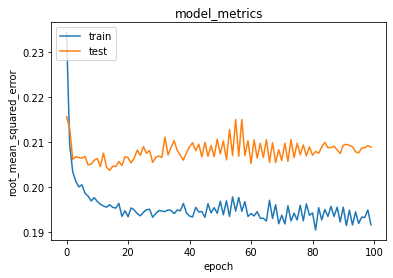

In [53]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Mendapatkan Rekomendasi Movie**

In [54]:
df_movies = new_movies
df = pd.read_csv('ratings.csv')
 
# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]

In [55]:
# Operator bitwise
movies_not_watched = df_movies[~df_movies['id'].isin(movies_watched_by_user.movieId.values)]['id'] 
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movies_to_movies_encoded.keys()))
)
 
movies_not_watched = [[movies_to_movies_encoded.get(x)] for x in movies_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movies_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [56]:
rating_movies = model.predict(user_movies_array).flatten()
 
top_rating_movies_indices = rating_movies.argsort()[-10:][::-1]
recommended_movies_ids = [
    movies_encoded_to_movies.get(movies_not_watched[x][0]) for x in top_rating_movies_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 15)
print('\n')
print('Movies with high ratings from user')
print('----' * 10)
 
top_movies_user = (
    movies_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

df_movies_rows = df_movies[df_movies['id'].isin(top_movies_user)]
for row in df_movies_rows.itertuples():
    print(row.movies_title, ':', row.movies_genre)
    
print('\n') 
print('----' * 10)
print('Top 10 movies recommendation')
print('----' * 10)
 
recommended_movies = df_movies[df_movies['id'].isin(recommended_movies_ids)]
for row in recommended_movies.itertuples():
    print(row.movies_title, ':', row.movies_genre)
 

43/43 [==============================] - 0s 1ms/step
Showing recommendations for users: 596


Movies with high ratings from user
----------------------------------------
Princess Mononoke (Mononoke-hime) (1997) : Action|Adventure|Animation|Drama|Fantasy
Donnie Darko (2001) : Drama|Mystery|Sci-Fi|Thriller
Thor: Ragnarok (2017) : Action|Adventure|Sci-Fi


----------------------------------------
Top 10 movies recommendation
----------------------------------------
Last Days of Disco, The (1998) : Comedy|Drama
More (1998) : Animation|Drama|Sci-Fi|IMAX
Crossing Delancey (1988) : Comedy|Romance
Lady Jane (1986) : Drama|Romance
Awful Truth, The (1937) : Comedy|Romance
Midnight Clear, A (1992) : Drama|War
Woman Under the Influence, A (1974) : Drama
Adam's Rib (1949) : Comedy|Romance
Safety Last! (1923) : Action|Comedy|Romance
Into the Woods (1991) : Adventure|Comedy|Fantasy|Musical
